## The Brazilian NSDI: A Strategic Framework for Management and Dissemination of Fundamental Geospatial Data Themes of UN-GGIM


---
### **Aims**

- This Jupyter notebook explore the current scenario of the Brazilian NSDI (INDE, in portuguese) in relation to the 14 Global Fundamental Geospatial Data Themes adopted by UN-GGIM.

- Through this open-source approach, we can gather all data from the INDE’s GeoPortal and categorize them into the fundamental themes and provide some important analysis.

### Install and load the necessary libraries

In [1]:
# Mains libraries to install (in case of using Google Colab)
%pip install owslib unidecode ipywidgets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.8 MB/s eta 0:00:00


In [2]:
# Import the libraries and modules to the project
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import re
import csv
import glob
import json
import urllib
from urllib.request import urlopen
from urllib.error import HTTPError
from urllib.error import URLError
from bs4 import BeautifulSoup
import ssl
import requests
from owslib.wms import WebMapService
from owslib.util import ServiceException
from requests.exceptions import RequestException, SSLError, ConnectionError
from urllib3.exceptions import MaxRetryError, NewConnectionError
import pandas as pd
from unidecode import unidecode
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

### Connect to Google Drive if using Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Check the current directory
%cd '/content/drive/MyDrive/UFPR_PPGCG_DSc/Disciplinas/CGEO7016_IDE/INDE_TemasDadosGeoespaciaisFundamentais/02_saídas'

/content/drive/MyDrive/UFPR_PPGCG_DSc/Disciplinas/CGEO7016_IDE/INDE_TemasDadosGeoespaciaisFundamentais/02_saídas


In [29]:
!ls

20240506_geoservicos_inde_scraped_TemasEscalas.csv  INDE_Temas_Globais_Fundamentais.xlsx
20240506_lista_geoservicos_inde.csv


In [30]:
# Define the directory path
path = os.getcwd()
path

'/content/drive/MyDrive/UFPR_PPGCG_DSc/Disciplinas/CGEO7016_IDE/INDE_TemasDadosGeoespaciaisFundamentais/02_saídas'


### Use a JSON request to retrieve the list of geoservices catalog available on the INDE's Geoportal






In [3]:
url = "https://inde.gov.br/api/catalogo/get"

response = requests.get(url, verify=False)  # Ignore SSL certificate verification
page_content = response.text

df_list = pd.read_json(page_content)
df_list.head()

,descricao,url,nivel_no,wmsAvailable,wfsAvailable,wcsAvailable,wmsGetCapabilities,wfsGetCapabilities,wcsGetCapabilities
0,ANA - Agência Nacional de Águas e Saneamento B...,https://www.snirh.gov.br/arcgis/services/INDE/...,Nacional,True,False,False,https://www.snirh.gov.br/arcgis/services/INDE/...,None,None
1,ANATEL - Agência Nacional de Telecomunicações,http://sistemas.anatel.gov.br:80/geoserver/ANA...,Nacional,True,True,True,http://sistemas.anatel.gov.br:80/geoserver/ANA...,http://sistemas.anatel.gov.br:80/geoserver/ANA...,http://sistemas.anatel.gov.br:80/geoserver/ANA...
2,ANM - Agência Nacional de Mineração,https://geoservicos.inde.gov.br/geoserver/ANM/ows,Nacional,True,False,False,https://geoservicos.inde.gov.br/geoserver/ANM/...,None,None
3,"ANP - Agência Nacional do Petróleo, Gás Natura...",https://gishub.anp.gov.br/geoserver/ows,Governo local,True,True,True,https://gishub.anp.gov.br/geoserver/ows?servic...,https://gishub.anp.gov.br/geoserver/ows?servic...,https://gishub.anp.gov.br/geoserver/ows?servic...
4,ANTT - Agência Nacional de Transporte Terrestres,https://geoservicos.inde.gov.br/geoserver/ANTT...,Nacional,True,True,True,https://geoservicos.inde.gov.br/geoserver/ANTT...,https://geoservicos.inde.gov.br/geoserver/ANTT...,https://geoservicos.inde.gov.br/geoserver/ANTT...


In [4]:
# How many geoservices are currently available in INDE's Geoportal?
len(df_list)

82

### Level of institutions Nodes participating in the INDE

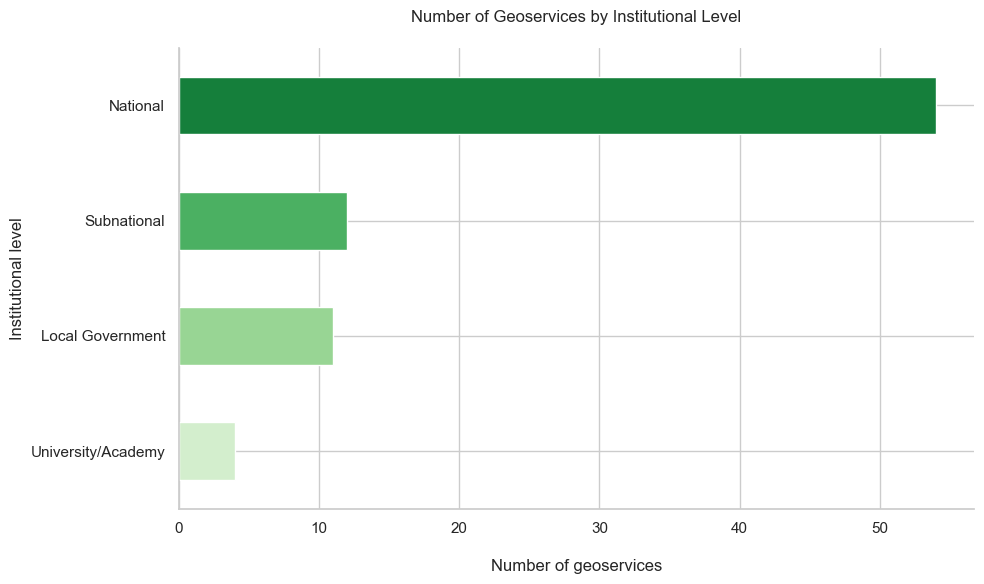

In [9]:
# Level of institutions Nodes participating in the INDE

df_list2 = df_list.copy()

# Translate categories
translation_dict = {
    'Nacional': 'National',
    'Subnacional': 'Subnational',
    'Governo local': 'Local Government',
    'Universidade/Academia': 'University/Academy'
}

df_list2['nivel_no'] = df_list2['nivel_no'].map(translation_dict)

# Group by 'nivel_no', count and sort in ascending order
level_counts = df_list2.groupby('nivel_no').size().sort_values()

# Cor palette by level counts
green_palette = sns.color_palette("Greens", len(level_counts))

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax = level_counts.plot(kind='barh', color=green_palette, ax=ax)
ax.set_title('Number of Geoservices by Institutional Level\n')
ax.set_xlabel('\nNumber of geoservices')
ax.set_ylabel('Institutional level')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Define path and filename
path = '../results'  # Path to the results directory
filename = 'fig1_geoservices_by_institutional_level.png'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save the figure with high resolution using os.path.join
full_path = os.path.join(path, filename)
plt.savefig(full_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

### Availability of geospatial services according to OGC standard

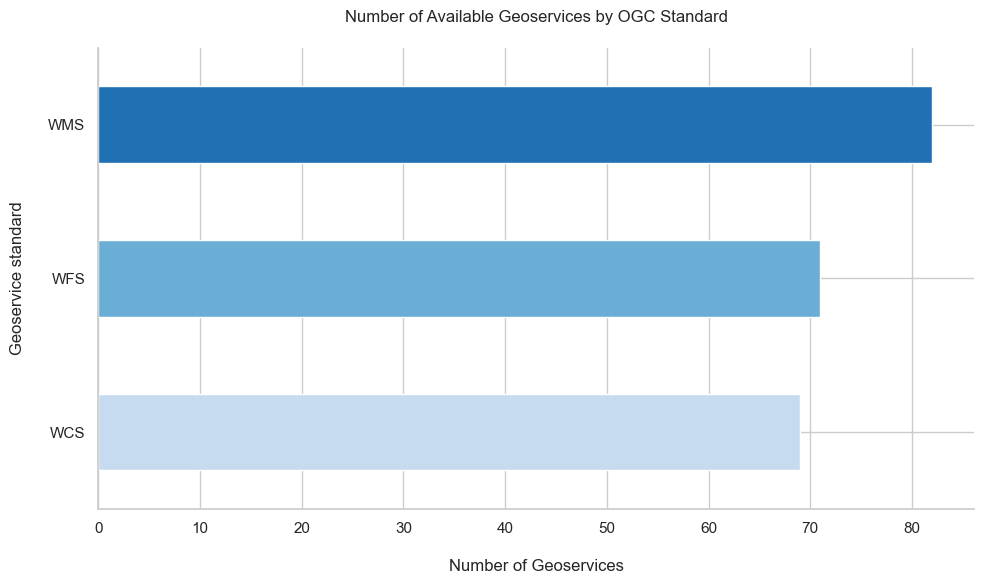

In [12]:
# Calculate the total available services for each type
service_counts = df_list[['wmsAvailable', 'wfsAvailable', 'wcsAvailable']].sum()

# Rename indices to more appropriate names
service_counts.index = ['WMS', 'WFS', 'WCS']

# Sort the values
service_counts = service_counts.sort_values()

# Color palette (using shades of blue to differentiate from previously used greens)
blue_palette = sns.color_palette("Blues", len(service_counts))

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax = service_counts.plot(kind='barh', color=blue_palette, ax=ax)
ax.set_title('Number of Available Geoservices by OGC Standard\n')
ax.set_xlabel('\nNumber of Geoservices')
ax.set_ylabel('Geoservice standard\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Define path and filename
path = '../results'  # Path to the results directory
filename = 'fig2_available_geoservices_OGC-standard.png'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save the figure with high resolution using os.path.join
full_path = os.path.join(path, filename)
plt.savefig(full_path, format='png', dpi=300, bbox_inches='tight')
plt.show()


### Scraping das camadas de dados geoespaciais disponíveis na INDE via geoserviços WMS


In [ ]:
# Desativar avisos de certificado SSL
requests.packages.urllib3.disable_warnings()

# Colunas do DataFrame
cols = ['nome_instituicao', 'nivel_no', 'wmsGetCapabilities',	'layer_name', 'titulo', 'abstract', 'estilo_padrao', 'SRC']
data = []
error_urls = []

start_time = time.time()

def fetch_url(url):
    try:
        response = requests.get(url, timeout=180, verify=False)  # Ignore SSL certificate verification
        response.raise_for_status()
        return WebMapService(url, timeout=180)
    except (SSLError, ConnectionError) as e:
        print(f"Network or SSL error on {url}: {e}")
    except RequestException as e:
        print(f"HTTP error on {url}: {e}")
    except Exception as e:
        print(f"Unexpected error on {url}: {e}")
    return None

for url in tqdm(df_list["wmsGetCapabilities"], desc="Processing URLs"):
    wms = fetch_url(url)
    if not wms:
        error_urls.append(url)
        continue

    try:
        for layer_name, layer_info in wms.contents.items():
            default_style = next(iter(layer_info.styles.values()))['title'] if layer_info.styles else "No default style"
            crs_options = layer_info.crsOptions
            data.append({
                'nome_instituicao': df_list.loc[df_list['wmsGetCapabilities'] == url, 'descricao'].iloc[0],
                'nivel_no': df_list.loc[df_list['wmsGetCapabilities'] == url, 'nivel_no'].iloc[0],
                'wmsGetCapabilities': df_list.loc[df_list['wmsGetCapabilities'] == url, 'wmsGetCapabilities'].iloc[0],
                'layer_name': layer_name,
                'titulo': layer_info.title,
                'abstract': layer_info.abstract,
                'estilo_padrao': default_style,
                'SRC': crs_options
            })
    except Exception as e:
        print(f"Error processing layers from {url}: {e}")
        error_urls.append(url)

df = pd.DataFrame(data, columns=cols)
elapsed_time = time.time() - start_time
print(f"Processing completed in {elapsed_time:.2f} seconds")
print("DataFrame:")
print(df.head())
if error_urls:
    print("Failed to process the following URLs:")
    for err_url in error_urls:
        print(err_url)

In [ ]:
df.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC
0,ANM - Agência Nacional de Mineração,Nacional,areas_bloqueio,Áreas de bloqueio,Poligonais das áreas bloqueadas para mineração.,None,"[EPSG:900913, EPSG:4326, EPSG:4674, EPSG:3857]"
1,ANM - Agência Nacional de Mineração,Nacional,arrendamentos,Arrendamentos,Poligonais dos processos minerários arrendados...,None,"[EPSG:900913, EPSG:4326, EPSG:4674, EPSG:3857]"
2,ANM - Agência Nacional de Mineração,Nacional,processos_minerarios_ativos,Processos minerários ativos,Poligonais dos processos minerários ativos (in...,None,"[EPSG:900913, EPSG:4326, EPSG:4674, EPSG:3857]"
3,ANM - Agência Nacional de Mineração,Nacional,protecao_fonte,Áreas de proteção de fonte,Poligonais das áreas de proteção de fonte asso...,None,"[EPSG:900913, EPSG:4326, EPSG:4674, EPSG:3857]"
4,ANM - Agência Nacional de Mineração,Nacional,reservas_garimpeiras,Reservas garimpeiras,Poligonais das reservas garimpeiras estabeleci...,None,"[EPSG:900913, EPSG:4326, EPSG:4674, EPSG:3857]"


In [ ]:
df.shape

(24845, 7)

In [ ]:
# Lista de urls onde retornou erro:
error_urls

['https://www.snirh.gov.br/arcgis/services/INDE/Camadas/MapServer/WMSServer?service=wms&request=GetCapabilities&version=1.3.0',
 'http://sistemas.anatel.gov.br:80/geoserver/ANATEL/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://cmr.funai.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cpafac.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cnptia.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cpamt.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cpatu.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cpact.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cnpgl.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cnpma.embrapa.br/geoserver/ows?service=wms&re

In [ ]:
## Código para Retentativa em URLs com Erro aplicando Backoff Exponencial

import random
# Desativação dos avisos SSL
requests.packages.urllib3.disable_warnings()

# Definindo a função de retentativa
def fetch_url_with_retry(url, retries=5, backoff_factor=0.3):
    for i in range(retries):
        try:
            response = requests.get(url, timeout=180, verify=False)
            response.raise_for_status()  # Verifica se a resposta foi bem-sucedida
            return WebMapService(url, timeout=180)  # Cria uma instância WebMapService
        except (SSLError, MaxRetryError, NewConnectionError, RequestException) as e:
            sleep_time = backoff_factor * (2 ** i) + random.uniform(0, 0.1)
            print(f"Retrying {url} in {sleep_time:.2f} seconds (Attempt {i+1}/{retries})")
            time.sleep(sleep_time)
        except Exception as e:
            print(f"Unexpected error on {url}: {e}")
            break
    return None

# Tentar novamente para URLs que falharam
successful_retries = []
new_error_urls = []

new_rows = []  # Lista para armazenar novas linhas

for url in tqdm(error_urls, desc="Retrying failed URLs"):
    wms = fetch_url_with_retry(url)
    if wms:
        try:
            for layer_name, layer_info in wms.contents.items():
                default_style = next(iter(layer_info.styles.values()))['title'] if layer_info.styles else "No default style"
                crs_options = layer_info.crsOptions
                new_rows.append({
                    'nome_instituicao': df_list.loc[df_list['wmsGetCapabilities'] == url, 'descricao'].iloc[0],
                    'layer_name': layer_name,
                    'titulo': layer_info.title,
                    'abstract': layer_info.abstract,
                    'estilo_padrao': default_style,
                    'SRC': crs_options
                })
            successful_retries.append(url)
        except Exception as e:
            print(f"Failed to process layers from {url} after retry: {e}")
            new_error_urls.append(url)
    else:
        new_error_urls.append(url)

# Convertendo a lista de novas linhas em DataFrame e concatenando com o DataFrame existente
if new_rows:
    new_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_df], ignore_index=True)

# Atualizando a lista de URLs com erro
error_urls = new_error_urls

# Exibindo resultados
if successful_retries:
    print("Successfully retried the following URLs:")
    for url in successful_retries:
        print(url)

if error_urls:
    print("Still failed to process the following URLs after retries:")
    for url in error_urls:
        print(url)

In [ ]:
import requests
from requests.exceptions import SSLError, Timeout, RequestException, ConnectionError
from owslib.wms import WebMapService
import time
from tqdm import tqdm
import random

# Desativação dos avisos SSL para evitar poluição visual nos logs
requests.packages.urllib3.disable_warnings()

# Função melhorada para retentativa com backoff exponencial
def fetch_url_with_retry(url, retries=5, backoff_factor=0.3):
    for i in range(retries):
        try:
            # Tentativa de requisição com tempo de espera aumentado
            response = requests.get(url, timeout=(10, 30), verify=False)
            response.raise_for_status()  # Verifica se a resposta foi bem-sucedida
            return WebMapService(url, timeout=30)  # Cria uma instância WebMapService com tempo de espera estendido
        except (Timeout, ConnectionError) as e:
            sleep_time = backoff_factor * (2 ** i) + random.uniform(0, 0.1)
            print(f"Timeout or connection error for {url}. Retrying in {sleep_time:.2f} seconds (Attempt {i+1}/{retries})")
            time.sleep(sleep_time)
        except (SSLError, RequestException) as e:
            print(f"SSL or Request error for {url}: {e}")
            break  # Se ocorrer um erro de SSL ou um erro grave de requisição, interrompe as retentativas
        except Exception as e:
            print(f"Unexpected error on {url}: {e}")
            break
    return None

successful_retries = []
new_error_urls = []
new_rows = []

for url in tqdm(error_urls, desc="Retrying failed URLs"):
    wms = fetch_url_with_retry(url)
    if wms:
        try:
            for layer_name, layer_info in wms.contents.items():
                default_style = next(iter(layer_info.styles.values()))['title'] if layer_info.styles else "No default style"
                crs_options = layer_info.crsOptions
                new_rows.append({
                    'nome_instituicao': df_list.loc[df_list['wmsGetCapabilities'] == url, 'descricao'].iloc[0],
                    'layer_name': layer_name,
                    'titulo': layer_info.title,
                    'abstract': layer_info.abstract,
                    'estilo_padrao': default_style,
                    'SRC': crs_options
                })
            successful_retries.append(url)
        except Exception as e:
            print(f"Failed to process layers from {url} after retry: {e}")
            new_error_urls.append(url)
    else:
        new_error_urls.append(url)

# Exibindo resultados das retentativas
print("Successfully retried the following URLs:")
for url in successful_retries:
    print(url)

print("Still failed to process the following URLs after retries:")
for url in new_error_urls:
    print(url)

Retrying failed URLs:   3%|▎         | 1/31 [00:00<00:19,  1.53it/s]

SSL or Request error for https://www.snirh.gov.br/arcgis/services/INDE/Camadas/MapServer/WMSServer?service=wms&request=GetCapabilities&version=1.3.0: 500 Server Error: Internal Server Error for url: https://www.snirh.gov.br/arcgis/services/INDE/Camadas/MapServer/WMSServer?service=wms&request=GetCapabilities&version=1.3.0
SSL or Request error for http://sistemas.anatel.gov.br:80/geoserver/ANATEL/ows?service=wms&request=GetCapabilities&version=1.3.0: 403 Client Error: Forbidden for url: http://sistemas.anatel.gov.br:80/geoserver/ANATEL/ows?service=wms&request=GetCapabilities&version=1.3.0
Timeout or connection error for https://cmr.funai.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.35 seconds (Attempt 1/5)
Timeout or connection error for https://cmr.funai.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.64 seconds (Attempt 2/5)
Timeout or connection error for https://cmr.funai.gov.br/geoserver/ows?service=wms&r

Retrying failed URLs:  10%|▉         | 3/31 [00:17<03:04,  6.58s/it]

Timeout or connection error for https://geoinfo.cpafac.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.37 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cpafac.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.64 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cpafac.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.23 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cpafac.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.45 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cpafac.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.80 seconds (Attempt 5/5)


Retrying failed URLs:  13%|█▎        | 4/31 [00:30<03:56,  8.75s/it]

Timeout or connection error for https://geoinfo.cnptia.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.37 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cnptia.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.60 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cnptia.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.29 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cnptia.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.45 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cnptia.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.82 seconds (Attempt 5/5)


Retrying failed URLs:  16%|█▌        | 5/31 [00:41<04:05,  9.44s/it]

Timeout or connection error for https://geoinfo.cpamt.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.31 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cpamt.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.65 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cpamt.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.23 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cpamt.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.49 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cpamt.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.85 seconds (Attempt 5/5)


Retrying failed URLs:  19%|█▉        | 6/31 [00:51<03:59,  9.58s/it]

Timeout or connection error for https://geoinfo.cpatu.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.38 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cpatu.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.68 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cpatu.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.24 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cpatu.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.41 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cpatu.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.84 seconds (Attempt 5/5)


Retrying failed URLs:  23%|██▎       | 7/31 [01:01<03:52,  9.67s/it]

Timeout or connection error for https://geoinfo.cpact.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.35 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cpact.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.70 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cpact.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.20 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cpact.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.46 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cpact.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.83 seconds (Attempt 5/5)


Retrying failed URLs:  29%|██▉       | 9/31 [01:14<02:53,  7.88s/it]

Unexpected error on https://geoinfo.cnpgl.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: EntityRef: expecting ';', line 1, column 5750 (<string>, line 1)
Timeout or connection error for https://geoinfo.cnpma.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.32 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cnpma.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.66 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cnpma.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.28 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cnpma.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.44 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cnpma.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in

Retrying failed URLs:  35%|███▌      | 11/31 [01:29<02:23,  7.16s/it]

Unexpected error on https://geoinfo.cnpms.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: EntityRef: expecting ';', line 1, column 5750 (<string>, line 1)
Timeout or connection error for https://geoinfo.cpap.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.31 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cpap.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.63 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cpap.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.25 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cpap.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.40 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cpap.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.85

Retrying failed URLs:  39%|███▊      | 12/31 [01:38<02:30,  7.95s/it]

Timeout or connection error for https://geoinfo.cppse.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.38 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cppse.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.64 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cppse.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.26 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cppse.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.43 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cppse.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.88 seconds (Attempt 5/5)


Retrying failed URLs:  45%|████▌     | 14/31 [01:52<01:57,  6.92s/it]

Unexpected error on https://geoinfo.cppsul.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: EntityRef: expecting ';', line 1, column 5750 (<string>, line 1)


Retrying failed URLs:  48%|████▊     | 15/31 [01:54<01:29,  5.56s/it]

Unexpected error on https://geoinfo.cnpasa.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: EntityRef: expecting ';', line 1, column 5750 (<string>, line 1)
Timeout or connection error for https://geoinfo.cpafrr.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.38 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cpafrr.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.69 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cpafrr.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.25 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cpafrr.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.45 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cpafrr.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retry

Retrying failed URLs:  52%|█████▏    | 16/31 [02:04<01:43,  6.87s/it]

Timeout or connection error for http://geoinfo.cnps.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.31 seconds (Attempt 1/5)
Timeout or connection error for http://geoinfo.cnps.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.62 seconds (Attempt 2/5)
Timeout or connection error for http://geoinfo.cnps.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.28 seconds (Attempt 3/5)
Timeout or connection error for http://geoinfo.cnps.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.49 seconds (Attempt 4/5)
Timeout or connection error for http://geoinfo.cnps.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.81 seconds (Attempt 5/5)


Retrying failed URLs:  58%|█████▊    | 18/31 [04:47<08:14, 38.00s/it]

Unexpected error on https://geoinfo.cnpsa.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: EntityRef: expecting ';', line 1, column 5750 (<string>, line 1)
Timeout or connection error for https://geoinfo.cnpm.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.30 seconds (Attempt 1/5)
Timeout or connection error for https://geoinfo.cnpm.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.64 seconds (Attempt 2/5)
Timeout or connection error for https://geoinfo.cnpm.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.26 seconds (Attempt 3/5)
Timeout or connection error for https://geoinfo.cnpm.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.41 seconds (Attempt 4/5)
Timeout or connection error for https://geoinfo.cnpm.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.87

Retrying failed URLs:  65%|██████▍   | 20/31 [07:35<09:57, 54.34s/it]

Unexpected error on https://geoinfo.cnpuv.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: EntityRef: expecting ';', line 1, column 5750 (<string>, line 1)


Retrying failed URLs:  68%|██████▊   | 21/31 [07:37<06:23, 38.37s/it]

Unexpected error on http://terrabrasilis.dpi.inpe.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: javax.xml.transform.TransformerException: Translator error
Translator error
Error occurred trying to write out metadata for layer: cerh_municipalities_diff_view
Layer cerh_municipalities_diff_view has no default style
Details:
org.geoserver.platform.ServiceException: javax.xml.transform.TransformerException: Translator error
	at org.geoserver.wms.capabilities.GetCapabilitiesResponse.write(GetCapabilitiesResponse.java:106)
	at org.geoserver.config.CapabilitiesCacheHeadersCallback$RevalidateTagResponse.write(CapabilitiesCacheHeadersCallback.java:133)
	at org.geoserver.ows.Dispatcher.response(Dispatcher.java:1029)
	at org.geoserver.ows.Dispatcher.handleRequestInternal(Dispatcher.java:269)
	at org.springframework.web.servlet.mvc.AbstractController.handleRequest(AbstractController.java:177)
	at org.springframework.web.servlet.mvc.SimpleControllerHandlerAdapter.handle(SimpleC

Retrying failed URLs:  71%|███████   | 22/31 [09:11<08:15, 55.11s/it]

SSL or Request error for http://portal.iphan.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: 503 Server Error: Service Unavailable for url: http://portal.iphan.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0
Timeout or connection error for https://idem.dhn.mar.mil.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.37 seconds (Attempt 1/5)
Timeout or connection error for https://idem.dhn.mar.mil.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.68 seconds (Attempt 2/5)
Timeout or connection error for https://idem.dhn.mar.mil.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.22 seconds (Attempt 3/5)
Timeout or connection error for https://idem.dhn.mar.mil.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.48 seconds (Attempt 4/5)
Timeout or connection error for https://idem.dhn.mar.mil.br/geoserver/ows?service=wms&req

Retrying failed URLs:  74%|███████▍  | 23/31 [09:27<05:47, 43.44s/it]

Timeout or connection error for http://geoserver.mdr.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.34 seconds (Attempt 1/5)
Timeout or connection error for http://geoserver.mdr.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.60 seconds (Attempt 2/5)
Timeout or connection error for http://geoserver.mdr.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.28 seconds (Attempt 3/5)
Timeout or connection error for http://geoserver.mdr.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.46 seconds (Attempt 4/5)
Timeout or connection error for http://geoserver.mdr.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.82 seconds (Attempt 5/5)


Retrying failed URLs:  81%|████████  | 25/31 [09:39<02:23, 23.99s/it]

SSL or Request error for http://sistemas.florestal.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: 503 Server Error: Service Unavailable for url: https://sistemas.florestal.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0
Timeout or connection error for https://iede.rs.gov.br/server/services/INDE/IEDE_RS/MapServer/WMSServer?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.31 seconds (Attempt 1/5)
Timeout or connection error for https://iede.rs.gov.br/server/services/INDE/IEDE_RS/MapServer/WMSServer?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.60 seconds (Attempt 2/5)
Timeout or connection error for https://iede.rs.gov.br/server/services/INDE/IEDE_RS/MapServer/WMSServer?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.21 seconds (Attempt 3/5)
Timeout or connection error for https://iede.rs.gov.br/server/services/INDE/IEDE_RS/MapServer/WMSServer?service=wms&request=GetCapabilities&version=1.

Retrying failed URLs:  84%|████████▍ | 26/31 [10:10<02:10, 26.11s/it]

Timeout or connection error for http://geoserver.prodemge.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.33 seconds (Attempt 1/5)
Timeout or connection error for http://geoserver.prodemge.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.68 seconds (Attempt 2/5)
Timeout or connection error for http://geoserver.prodemge.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.27 seconds (Attempt 3/5)
Timeout or connection error for http://geoserver.prodemge.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.49 seconds (Attempt 4/5)
Timeout or connection error for http://geoserver.prodemge.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.82 seconds (Attempt 5/5)


Retrying failed URLs:  87%|████████▋ | 27/31 [11:11<02:25, 36.29s/it]

Timeout or connection error for http://geo.seplande.al.gov.br/teogc/terraogcwms.cgi?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.39 seconds (Attempt 1/5)
Timeout or connection error for http://geo.seplande.al.gov.br/teogc/terraogcwms.cgi?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 0.69 seconds (Attempt 2/5)
Timeout or connection error for http://geo.seplande.al.gov.br/teogc/terraogcwms.cgi?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 1.25 seconds (Attempt 3/5)
Timeout or connection error for http://geo.seplande.al.gov.br/teogc/terraogcwms.cgi?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 2.44 seconds (Attempt 4/5)
Timeout or connection error for http://geo.seplande.al.gov.br/teogc/terraogcwms.cgi?service=wms&request=GetCapabilities&version=1.3.0. Retrying in 4.89 seconds (Attempt 5/5)


Retrying failed URLs:  94%|█████████▎| 29/31 [12:13<01:01, 30.89s/it]

SSL or Request error for https://geoserver.sefin.fortaleza.ce.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0: 403 Client Error: Forbidden for url: https://geoserver.sefin.fortaleza.ce.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0


Retrying failed URLs:  97%|█████████▋| 30/31 [12:13<00:21, 21.73s/it]

SSL or Request error for http://bhmap.pbh.gov.br/v2/api/idebhgeo/ows?service=wms&request=GetCapabilities&version=1.3.0: 403 Client Error: Forbidden for url: http://bhmap.pbh.gov.br/v2/api/idebhgeo/ows?service=wms&request=GetCapabilities&version=1.3.0


Retrying failed URLs: 100%|██████████| 31/31 [12:15<00:00, 23.74s/it]

Unexpected error on https://sigamapa.santoandre.sp.gov.br/geoserver/siga/ows?service=wms&request=GetCapabilities&version=1.3.0: javax.xml.transform.TransformerException: Translator error
Translator error
Successfully retried the following URLs:
Still failed to process the following URLs after retries:
https://www.snirh.gov.br/arcgis/services/INDE/Camadas/MapServer/WMSServer?service=wms&request=GetCapabilities&version=1.3.0
http://sistemas.anatel.gov.br:80/geoserver/ANATEL/ows?service=wms&request=GetCapabilities&version=1.3.0
https://cmr.funai.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0
https://geoinfo.cpafac.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0
https://geoinfo.cnptia.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0
https://geoinfo.cpamt.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0
https://geoinfo.cpatu.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&vers

In [ ]:
df.shape

##### Histograma de frequência das Insituições participantes da INDE, para as quais houve retorno nas requisições

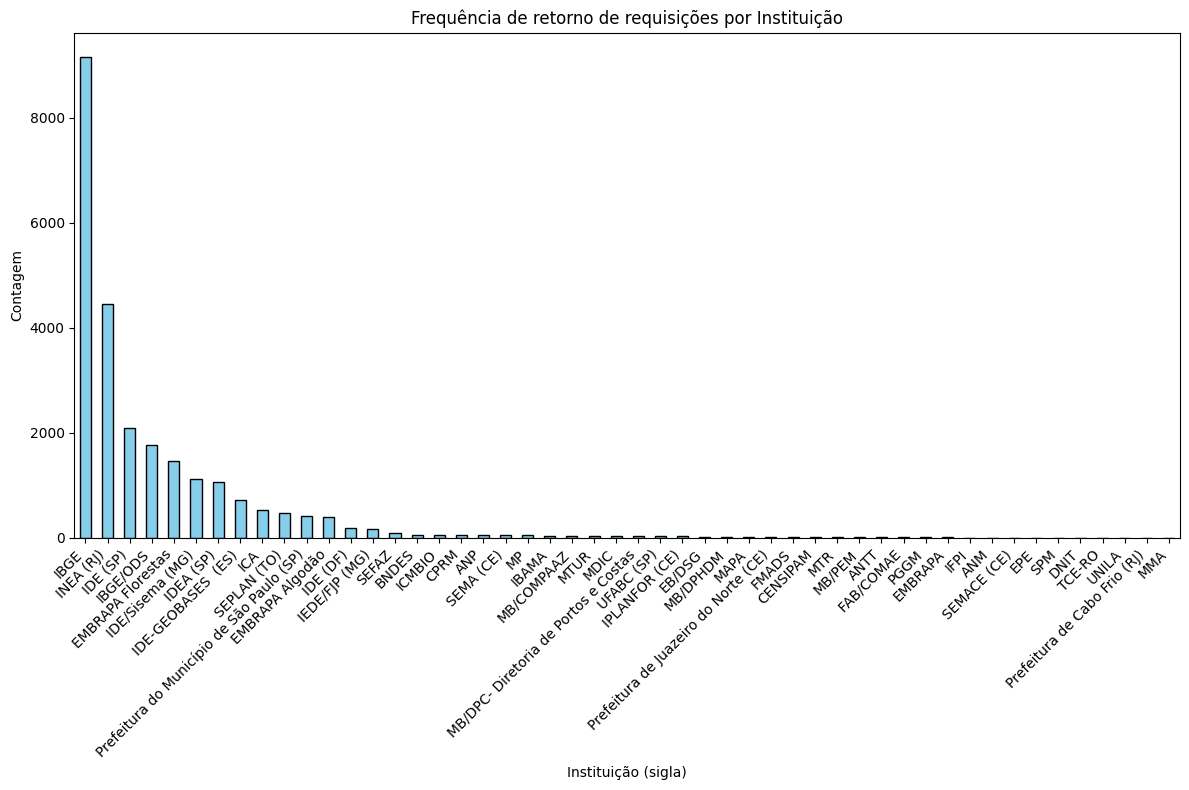

In [ ]:
# Função para extrair a sigla da instituição
def extract_initials(name):
    return name.split(' - ')[0]

# Aplicar a função para criar uma nova coluna com as siglas
df['sigla_instituicao'] = df['nome_instituicao'].apply(extract_initials)

# Contar o número de ocorrências de cada sigla de instituição
institution_count = df['sigla_instituicao'].value_counts()

# Criar um gráfico de barras
plt.figure(figsize=(12, 8))
institution_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequência de retorno de requisições por Instituição')
plt.xlabel('Instituição (sigla)')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Contar o número de ocorrências de cada instituição
institution_count = df['nome_instituicao'].value_counts()

# Exibir os resultados
print(institution_count)

nome_instituicao
IBGE - Instituto Brasileiro de Geografia e Estatística                                        9164
INEA (RJ) - Instituto Estadual do Ambiente                                                    4446
IDE (SP) - Infraestrutura de Dados Espaciais de São Paulo                                     2100
IBGE/ODS - Objetivos de Desenvolvimento Sustentável                                           1768
EMBRAPA Florestas - Empresa Brasileira de Pesquisa Agropecuária                               1469
IDE/Sisema (MG) - IDE - Sistema Estadual de Meio Ambiente e Recursos Hídricos                 1117
IDEA (SP) - Infraestrutura de Dados Espaciais Ambientais do Estado de São Paulo               1063
IDE-GEOBASES  (ES) - Sistema Integrado de Bases Geoespaciais do Estado do Espírito Santo       727
ICA - Instituto de Cartografia Aeronáutica                                                     523
SEPLAN (TO) - Secretaria do Planejamento e Orçamento do Estado do Tocantins                 

In [ ]:
# Função para extrair a sigla da instituição
def extract_initials(name):
    return name.split(' - ')[0]

# Aplicar a função para criar novas colunas de siglas em ambos os DataFrames
df_list['sigla'] = df_list['descricao'].apply(extract_initials)
df['sigla'] = df['nome_instituicao'].apply(extract_initials)

# Conjunto de siglas únicas em df_list
unique_siglas_list = set(df_list['sigla'].unique())

# Conjunto de siglas únicas em df
unique_siglas_df = set(df['sigla'].unique())

# Encontrar as siglas que estão em df_list mas não em df
missing_institutions = unique_siglas_list.difference(unique_siglas_df)

# Calcular o percentual de instituições não presentes
percent_missing = len(missing_institutions) / len(unique_siglas_list) * 100

# Imprimir as instituições que não estão presentes e o percentual
print("Instituições não presentes em df:")
for inst in missing_institutions:
    print(inst)
print(f"\nPercentual de instituições não presentes: {percent_missing:.2f}%")

Instituições não presentes em df:
PRODEMG (MG)
SEMA (CE)
CMR/Funai
SFB
 FAB/COMAE
SEFIN
SEPLAN (TO)
Prefeitura de Belo Horizonte (MG)
MB/DHN
EMBRAPA Agricultura Digital
Prefeitura Municipal de Santo André
UNILA
SEPLAG (AL)

Percentual de instituições não presentes: 16.05%


### Salvando os resultados em um arquivo CSV

In [ ]:
# Salva resultado em arquivo CSV

def save_df_to_csv(df, filename):
    """
    Save the provided DataFrame to a CSV file.

    Parameters:
        df (pd.DataFrame): DataFrame to be saved.
        filename (str): File name or path where the CSV will be saved.
    """
    if df is not None and not df.empty:
        try:
            df.to_csv(filename, index=False, encoding='utf-8')
            print(f"DataFrame saved successfully to '{filename}'")

        except Exception as e:
            print(f"Failed to save DataFrame to '{filename}': {e}")

    else:
        print("DataFrame is empty or not defined. No file was saved.")

In [ ]:
# Usage example (assuming 'df' is your DataFrame)
save_df_to_csv(df_list, 'lista_geoservicos_inde_20240506.csv')

DataFrame saved successfully to 'lista_geoservicos_inde_20240506.csv'


In [ ]:
# Caso necessário, importando novamente o CSV com todos os registros
file = '/20240506_geoservicos_inde_scraped_TemasEscalas.csv'
df_inde_scraped = pd.read_csv(path + file)
df_inde_scraped.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,tema_fundamental,escala
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,not in dict
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,not in dict
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,not in dict
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,not in dict
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Recursos Hídricos,not in dict


In [ ]:
df_inde_scraped.shape

(26462, 9)

### Identificação dos temas de Dados Geoespaciais Fundamentais a partir das camadas dos geoserviços

In [ ]:
# Criando novas colunas no dataframe

new_cols = ['tema_fundamental', 'escala']

df_inde_scraped[new_cols] = ""

df_inde_scraped.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,tema_fundamental,escala
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",,
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",,
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",,
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",,
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",,


In [ ]:
df_inde_scraped.shape

(26462, 9)

#### Palavras-chaves

In [ ]:
# Conjunto de palavras-chave para as correspodências
temas = {
    'Infraestrutura Global de Referência Geodésica': ['Geofísica', 'GNSS', 'GPS', 'BDG', 'geodesico',
                                                      'Banco de Dados Geodésicos', 'doppler', 'rmpg', 'vértice', 'Rede de Referência',
                                                      'Rede Gravimétrica', 'Rede Planimétrica', 'Rede altimétrica', 'Ondulação geoidal',
                                                      'sirgas', 'pto controle', 'Pontos de Referência', 'rbmc'],
    'Endereços': ['endereço', 'endereçamento', 'Habitação', 'Rural', 'Urbano', 'número'],
    'Edifícios e Localidades': ['edif', 'edificação','aglomerado', 'aldeia', 'loc_', 'localidade', 'assentamento', 'povoado','lml_', 'lim_', 'cidade', 'rmpg', 'capitais',
                                'cidade', 'capital','Mancha Urbana', 'area construída', 'wac', 'vila', 'Áreas Urb', 'Areas Urb', 'sede'],
    'Elevação e Profundidade': ['batimetria', 'hipsometria', 'hipsometrico', 'curva de nivel', 'curvas de nivel', 'curva_nivel',
                                'curvas de nível', 'Curva Mestra', 'pico', 'ponto cotado', 'ponto_cotado', 'Altimetry', 'Altimetria',
                                'relevo', 'declividade', 'mds', 'Pontos de Referência', 'Modelo Númerico', 'modelo de elevação' 'Mapeamento Náutico', 'Mapeamento Aeronáutico'],
    'Estruturas Territoriais': ['área funcional', 'zonas', 'território', 'riscos', 'estatísticas econômicas',
                                'agricultura', 'pecuária', 'justiça', 'limites', 'Divisão Politico Administrativa (DPA)', 'Unidade_',
                                'Regiões Administrativas', 'Distrito', 'Mesorregiões', 'Fronteira', 'Área de Proteção', 'Região de', 'Microrregiões', 'Município',
                                'Áreas prioritárias', 'Áreas de bloqueio', 'Arrendamentos', 'localidade', 'limite', 'Unidades de Conservação'],
    'Nomes Geográficos': ['nome', 'nome geográfico', 'nomes geográficos', 'toponímia', 'nome local',
                          'aglomerado', 'aldeia', 'localidade', 'povoado', 'cidade', 'vila', 'Mancha Urbana', 'Áreas Urb'],
    'Geologia e Solos': ['solos', 'rocha', 'geológico', 'geológica', 'Fraturas Geológicas',
                         'Pontos Geológicos', 'Mapa Geológico', 'litologia', 'forma de relevo', 'geomorf', 'pedológ', 'pedologia', 'aquífero', 'petróleo',
                         'Carta Geológica', 'banco de areia', 'recife', 'duna', 'recursos minerais', 'combustíveis fósseis', 'Zon-'],
    'Cobertura e Uso da Terra': ['mapa de uso e cobertura da terra', 'uso e cobertura da terra', 'Cobertura e Uso da Terra', 'Uso e Cobertura', 'uso e cobertura',
                                 'uso e ocupação', 'bioma', 'biome', 'macega', 'vegetação', 'pivo central', 'pantano', 'fisiografico', 'Florestal',
                                 'floresta', 'extrativismo', 'ext mineral', 'mangue', 'restinga', 'veg_', 'desforestation', 'mata', 'área plantada',
                                 'Uso e ocupação do solo', 'Land-use and land cover', 'Zoneamento', 'area_plant', 'Reserva', 'CAR - Uso Restrito', 'CAR - Uso Consolida',
                                 'Servidão Ambiental', 'área irrigada', 'remanescentes', 'areaplantada', 'Focos de Queimadas'],
    'Parcelas de Terreno': ['Uso e Ocupacao Lote', 'quadra', 'lote', 'loteamento', 'parcela', 'parcelas', 'CAR - Propriedades', 'bairros', 'Condominio',
                            'bc25', 'bc50', 'bc100', 'parcelas', 'distrito', 'Terra Indigena', 'Área plantada_'],
    'Ortoimagens': ['ortofoto', 'ortoimagem', 'ortomosaico', 'ortofotomosaico', 'sentinel', '_img_', 'rapideye', 'ram_colorimetria', 'mosaico', 'landsat'],
    'Infraestrutura Física': ['aeroporto', 'aero', 'escolas', 'creche', 'universidade', 'ensino', 'saúde', 'posto', 'upa', 'ubs', 'centro de referencia',
                              'estabelecimentos de', 'abastecimento', 'estação de tratamento', 'barragem', 'barragens', 'hidrel', 'termel', 'pista',
                              '_Comunic_', 'Desportivo_Lazer', 'Portuario', 'aeró', 'torre', 'ponte', 'patio', 'porto', 'postos', 'trecho duto', 'trecho energia',
                              'transmissão de', 'rede coleta', 'Indústria', 'Comércio e Serviços', 'usina', 'Polícia', 'Delegacia', 'anatel', 'ZonBarragem', '_Energia_',
                              'equipamento', 'linhas de Transmissao', 'linha de Transmissao', 'Campo_Quadra', 'serviço', 'Telefonica', 'indicador', 'potenciais', 'indice',
                              'ODS', 'serviços públicos', 'Estações de Tratamento'],
    'Distribuição Populacional': ['distribuição pop', 'comunidades', 'Aglomerados', 'Urbanização', 'povo', 'pessoa', 'aluno', 'população',
                                  'nascimento', 'Proporção de acesso a', 'habitantes', 'taxas de emprego', 'renda', 'Densidade Populacional',
                                  'renda familiar', 'condições de vida', 'Densidade de acessos', 'unidades hab', 'domicilio', 'domicílio', 'analfabetismo',
                                  'crianças', '_pessoas_', '_diversidade_', 'óbito', 'mortalidade', 'Razão', 'migração', 'imigrantes', 'migrantes', 'emigração',
                                  'densidade demo', 'Indicador de Coleta', 'Aglomerados', 'Porcentagem de domicílios', 'Percentagem de Adeptos', 'IDH'],
    'Redes de Transporte': ['Entroncamento', 'Passagem', 'Passag', 'Travessia', 'Túnel', 'Vias', 'Trecho_Rodoviario', 'Trecho Rodoviário',
                            'Via_Deslocamento', 'Via Deslocamento', 'Trecho Ferroviario', 'Arruamento', 'Caminho_Aereo', 'Caminho_Carrocavel',
                            'Canal de acesso', 'Sistemas de Trens', 'tunel', 'Estradas', 'aeródromos', 'ferrovia', 'Linha Metropolitana', 'Trechos de Logradouros',
                            'Logradouro', '_rod_', 'rodovia', 'hidrovia', '_ferr_', 'Metrô', 'Sistema Viário', 'Rodovia', 'Trilha'],
    'Recursos Hídricos': ['hid_', 'Drenagem', 'Trecho Massa Dagua', 'Massa Dagua', 'Nascente', 'Queda Dagua', 'Corredeira', 'Volume de Água', 'Disponibilidade Hídrica',
                          'Rios', 'CAR - Rio', 'Balanço Hídrico', 'Hidrografia', 'Foz Marítima', 'Foz', 'Bacia Hidrográfica', 'Maré', 'Qualidade da Água',
                          'Índice de Conformidade', 'Precipitação', 'corpos hídricos', 'corpos de água', 'água', 'Rede de drenagem', '_corpos_dagua', 'Lagos e Lagoas',
                          'Lagoa', 'CURSODAGUA', 'AGUA_COSTEIRA', 'Qualidade das Águas', 'Qualidade de Água', 'pH', 'Mananciais', '_hid_', 'mangue', 'agua', 'Quebramar',
                          'açude', 'Represa', 'hidrico', 'turbidez', 'salinidade', 'serie', 'Atlas Água', 'Atlas irrigação'],
    'N/A': []
    }

In [ ]:
df2_inde_scraped = df_inde_scraped.copy()

# Função para preprocessar texto
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = unidecode(text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Função para preprocessar palavras-chave
def preprocess_keyword(keyword):
    keyword = keyword.lower()
    keyword = unidecode(keyword)
    keyword = re.sub(r'\s+', ' ', keyword)
    keyword = keyword.strip()
    return keyword

preprocessed_temas = {theme: [preprocess_keyword(keyword) for keyword in keywords] for theme, keywords in temas.items()}

# Função para associar tema com base em várias colunas
def associar_tema_por_colunas(row, colunas):
    for coluna in colunas:
        texto = preprocess_text(row[coluna])
        if texto:  # Verifica se o texto não está vazio
            for tema, palavras_chave in preprocessed_temas.items():
                for palavra_chave in palavras_chave:
                    if re.search(r'{}' .format(re.escape(palavra_chave)), texto, re.IGNORECASE):
                        return tema
    return 'not in dict'  # Retorna 'not in dict' se nenhum tema for encontrado

# Colunas a serem verificadas em ordem de prioridade
colunas = ['titulo', 'abstract', 'layer_name', 'estilo_padrao']

# Aplicar a função associar_tema_por_colunas para cada linha do DataFrame
df2_inde_scraped['tema_fundamental'] = df2_inde_scraped.apply(associar_tema_por_colunas, colunas=colunas, axis=1)

In [ ]:
df2_inde_scraped.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,tema_fundamental,escala
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Recursos Hídricos,


In [ ]:
# Exibindo os temas encontrados
print(df2_inde_scraped['tema_fundamental'].unique())

['Estruturas Territoriais' 'Recursos Hídricos' 'not in dict'
 'Infraestrutura Física' 'Cobertura e Uso da Terra' 'Endereços'
 'Parcelas de Terreno' 'Edifícios e Localidades'
 'Infraestrutura Global de Referência Geodésica' 'Redes de Transporte'
 'Geologia e Solos' 'Elevação e Profundidade' 'Ortoimagens'
 'Distribuição Populacional' 'Nomes Geográficos']


#### Plot Temas fundamentais associados por title

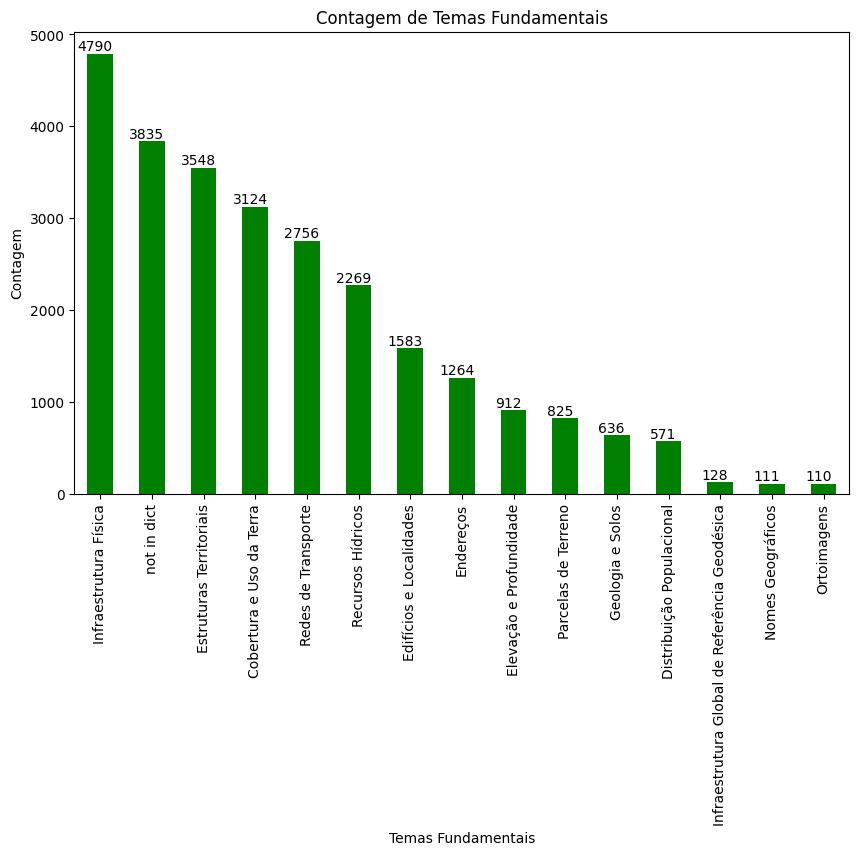

In [ ]:
# Contagem dos temas fundamentais
tema_counts = df2_inde_scraped['tema_fundamental'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
bars = tema_counts.plot(kind='bar', color='green')
plt.title('Contagem de Temas Fundamentais')
plt.xlabel('Temas Fundamentais')
plt.ylabel('Contagem')

# Adicionando rótulos com os valores em cima de cada barra
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, f'{int(bar.get_height())}', ha='center', va='bottom')

plt.show()

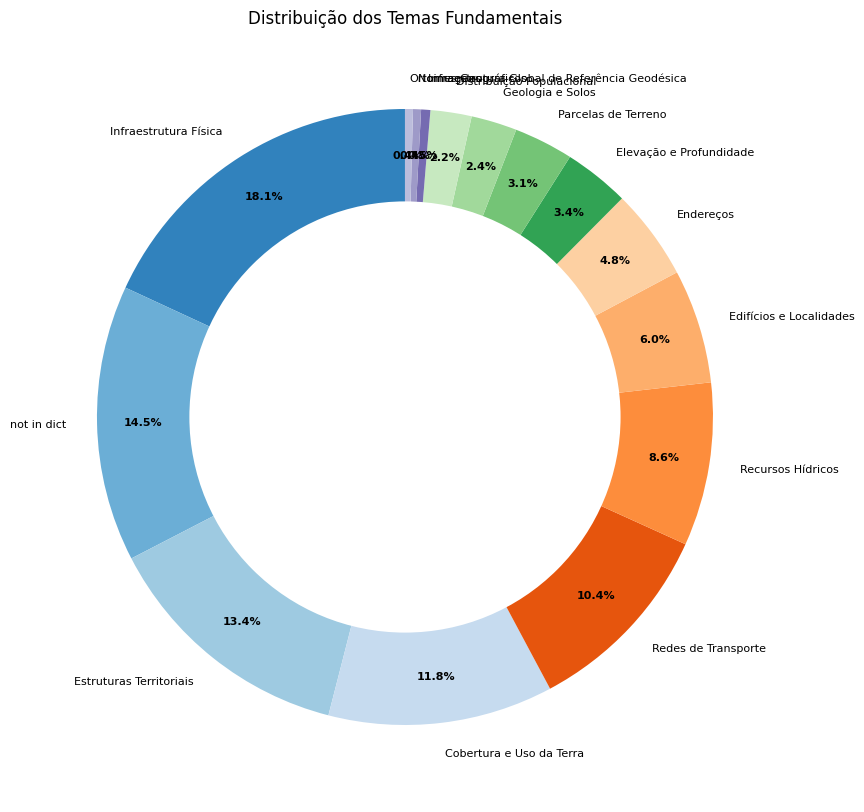

In [ ]:
import matplotlib.pyplot as plt

# Supondo que temos os dados carregados em df_inde_scraped2 e a coluna de interesse é 'tema_fundamental_t'
tema_counts = df2_inde_scraped['tema_fundamental'].value_counts()

# Definindo cores personalizadas para cada categoria
colors = plt.cm.tab20c.colors  # usando a paleta tab20c para uma variedade de cores

# Criando o gráfico de rosca
fig, ax = plt.subplots(figsize=(15, 10))
wedges, texts, autotexts = ax.pie(tema_counts, labels=tema_counts.index, autopct='%1.1f%%',
                                  startangle=90, colors=colors, pctdistance=0.85)

# Desenha um círculo no meio para criar o efeito de rosca
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Ajustando os autotexts para não sobrepor o gráfico
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)

# Adicionando título
plt.title('Distribuição dos Temas Fundamentais')

# Removendo a legenda externa, já que as etiquetas estão incluídas no gráfico
ax.legend().set_visible(False)

# Exibindo o gráfico
plt.show()

### Manipulação dos dados p/ extração de informações de Escalas cartográficas

In [ ]:
# Dicionário de escalas e padrões regex correspondentes
escalas = {
    '1k': r'1:1000',
    '2k': r'1:2000|lote',
    '10k': r'1:10000|10mil|10 mil',
    '25k': r'1:25.000|25mil|bc25|scn25',
    '50k': r'1:50.000|50mil',
    '70k': r'1:70.000|70mil',
    '100k': r'1:100.000|100mil',
    '250k': r'1:250.000|250mil|bc250',
    '450k': r'1:450.000|450mil',
    '500k': r'1:500.000|500mil',
    '1M': r'1:1.000.000|milhão|milionésimo',
    '1100k': r'1:1.100.000',
    '1500k': r'1:1.500.000',
    '2M': r'1:2.000.000',
    '2500k': r'1:2.500.000',
    '4500k': r'1:4.500.000',
    '5M': r'1:5.000.000',
    '6M': r'1:6.000.000',
    '6400k': r'1:6.400.000',
    '7M': r'1:7.000.000',
    '8M': r'1:8.000.000',
    '8500k': r'1:8.500.000',
    '18M': r'1:18.000.000',
    '20M': r'1:20.000.000',
    '50M': r'1:50.000.000',
    '70M': r'1:70.000.000'
}

In [ ]:
df3_inde_scraped = df2_inde_scraped.copy()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

def associar_escala_por_colunas(row, colunas, escalas):
    for coluna in colunas:
        texto = preprocess_text(row[coluna])
        if texto:  # Verifica se o texto não está vazio
            for escala, pattern in escalas.items():
                if re.search(pattern, texto, re.IGNORECASE):
                    return escala
    return 'not in dict'  # Retorna 'not in dict' se nenhuma escala for encontrada


# Lista de colunas a verificar em ordem de prioridade
colunas = ['titulo', 'abstract', 'layer_name', 'estilo_padrao']

# Aplicar a função ao DataFrame
df3_inde_scraped['escala'] = df3_inde_scraped.apply(lambda row: associar_escala_por_colunas(row, colunas, escalas), axis=1)

In [ ]:
df3_inde_scraped.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,tema_fundamental,escala
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,not in dict
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,not in dict
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,not in dict
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Estruturas Territoriais,not in dict
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",Recursos Hídricos,not in dict


In [ ]:
df3_inde_scraped.shape

(26462, 9)

In [ ]:
# Verficando as escalas encontrada
print(df3_inde_scraped['escala'].unique())

['not in dict' '1M' '100k' '250k' '25k' '50k' '20M' '18M' '1500k' '1100k'
 '2500k' '4500k' '6M' '2M' '7M' '2k' '500k' '70k' '5M' '1k' '10k' '450k']


##### Plot das Escalas encontradas nas camadas dos geoserviço

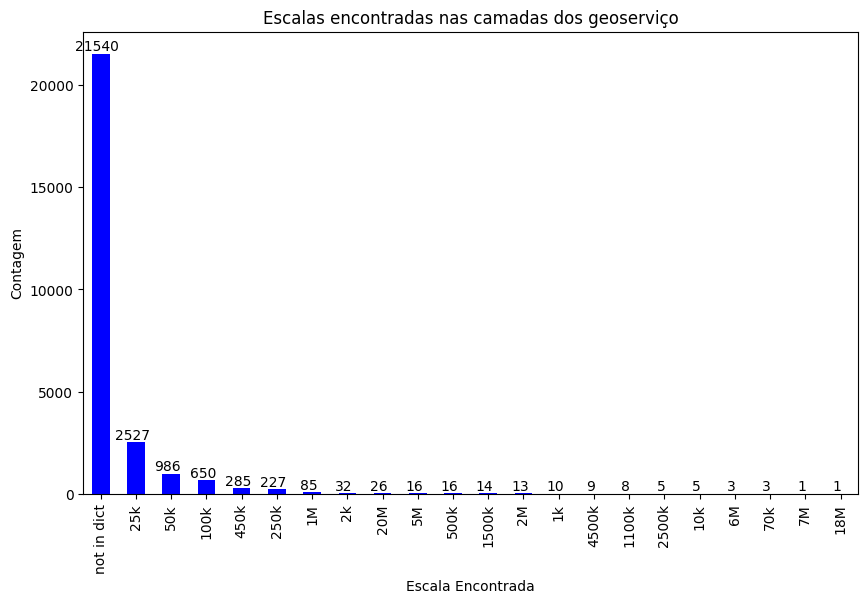

In [ ]:
# Contagem dos temas fundamentais
tema_counts = df3_inde_scraped['escala'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
bars = tema_counts.plot(kind='bar', color='blue')
plt.title('Escalas encontradas nas camadas dos geoserviço')
plt.xlabel('Escala Encontrada')
plt.ylabel('Contagem')

# Adicionando rótulos com os valores em cima de cada barra
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, f'{int(bar.get_height())}', ha='center', va='bottom')

plt.show()

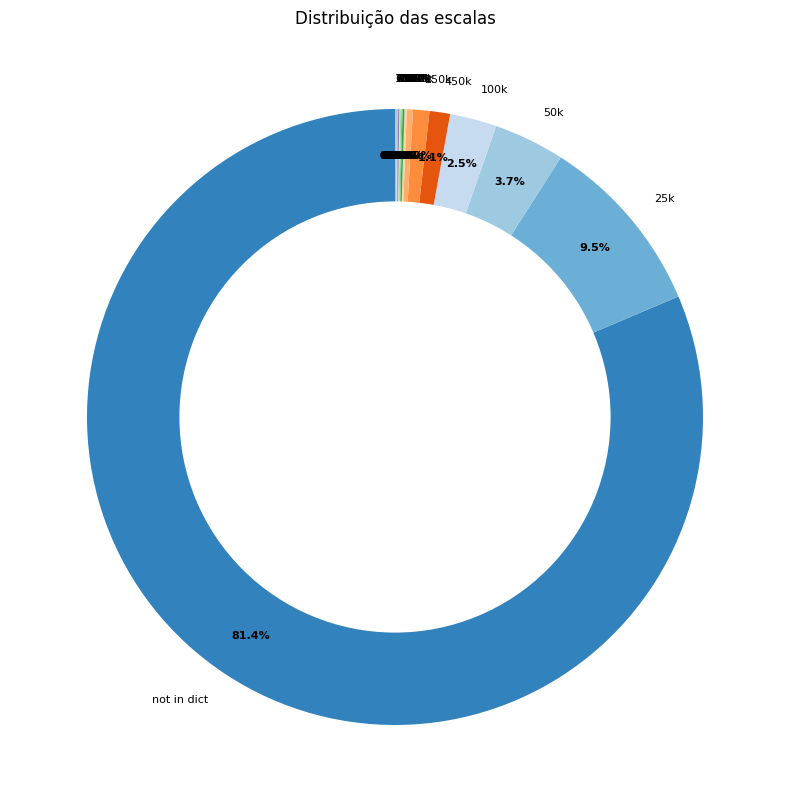

In [ ]:
import matplotlib.pyplot as plt

# Supondo que temos os dados carregados em df_inde_scraped2 e a coluna de interesse é 'tema_fundamental_t'
tema_counts = df3_inde_scraped['escala'].value_counts()

# Definindo cores personalizadas para cada categoria
colors = plt.cm.tab20c.colors  # usando a paleta tab20c para uma variedade de cores

# Criando o gráfico de rosca
fig, ax = plt.subplots(figsize=(15, 10))
wedges, texts, autotexts = ax.pie(tema_counts, labels=tema_counts.index, autopct='%1.1f%%',
                                  startangle=90, colors=colors, pctdistance=0.85)

# Desenha um círculo no meio para criar o efeito de rosca
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Ajustando os autotexts para não sobrepor o gráfico
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)

# Adicionando título
plt.title('Distribuição das escalas')

# Removendo a legenda externa, já que as etiquetas estão incluídas no gráfico
ax.legend().set_visible(False)

# Exibindo o gráfico
plt.show()

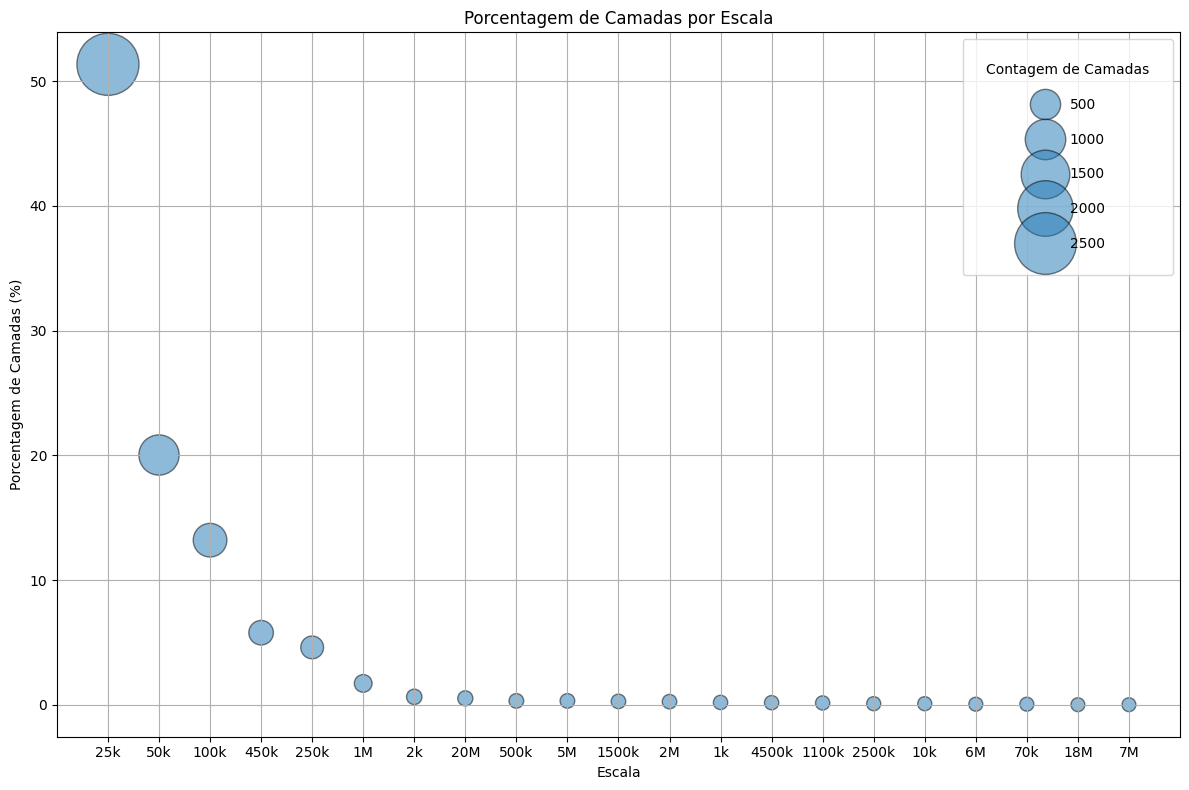

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar 'not in dict'
df_filtered = df3_inde_scraped[df3_inde_scraped['escala'] != 'not in dict']

# Contagem das escalas
escala_counts = df_filtered['escala'].value_counts()

# Calcular a porcentagem de camadas para cada escala
porcentagem_camadas = (escala_counts / escala_counts.sum()) * 100
df_plot = pd.DataFrame({'Escala': porcentagem_camadas.index, 'Porcentagem de Camadas': porcentagem_camadas, 'Contagem': escala_counts})

# Tamanho maior para o gráfico
plt.figure(figsize=(12, 8))

# Usar seaborn para criar um gráfico de bolhas
sns.scatterplot(data=df_plot, x='Escala', y='Porcentagem de Camadas', size='Contagem', sizes=(100, 2000), alpha=0.5, edgecolor='black', linewidth=1)

# Ajustar legendas e títulos
plt.title('Porcentagem de Camadas por Escala')
plt.xlabel('Escala')
plt.ylabel('Porcentagem de Camadas (%)')
plt.grid(True)  # Adicionar grid para melhor visualização

# Ajustar o layout para evitar sobreposições e ajustar a legenda
plt.legend(title='Contagem de Camadas', labelspacing=1.5, borderpad=1.7)
plt.tight_layout()

# Exibir o gráfico
plt.show()

SelectMultiple(description='Temas:', index=(4, 10), layout=Layout(height='270px', width='300'), options=('Estr…

Button(description='Atualizar Gráfico', style=ButtonStyle())

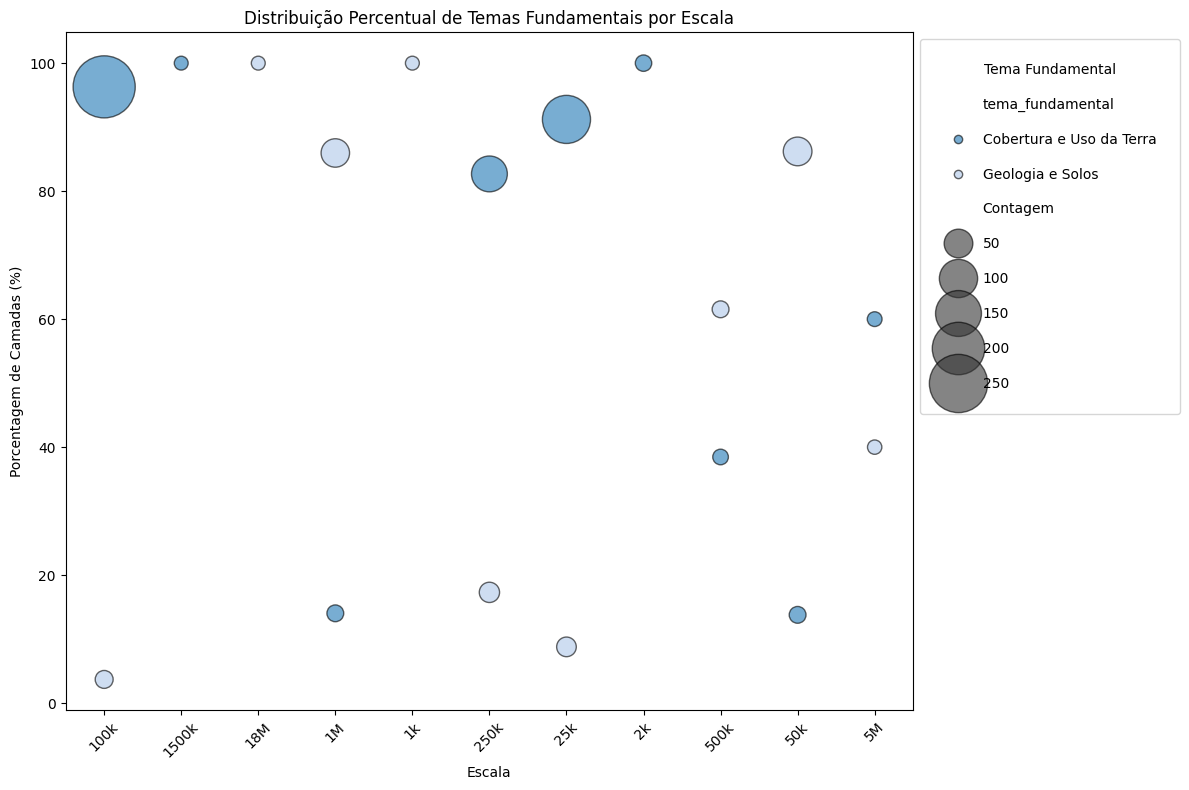

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Suponha que df3_inde_scraped já esteja definido
# Função de conversão de escalas para formato numérico para ordenação
def scale_to_numeric(x):
    if 'k' in x:
        return int(x.replace('k', '')) * 1000
    elif 'M' in x:
        return int(x.replace('M', '')) * 1000000
    return int(x)

# Preparação e plotagem dos dados
def plot_filtered_data(selected_themes):
    clear_output(wait=True)
    display(selector, button)  # Redisplay widgets
    filtered_data = df3_inde_scraped[(df3_inde_scraped['escala'] != 'not in dict') & (df3_inde_scraped['tema_fundamental'] != 'not in dict') & (df3_inde_scraped['tema_fundamental'].isin(selected_themes))]
    filtered_data['escala_num'] = filtered_data['escala'].apply(scale_to_numeric)
    filtered_data.sort_values('escala_num', inplace=True)

    grouped = filtered_data.groupby(['escala', 'tema_fundamental']).size().reset_index(name='Contagem')
    grouped['Total por Escala'] = grouped.groupby('escala')['Contagem'].transform('sum')
    grouped['Porcentagem de Camadas'] = (grouped['Contagem'] / grouped['Total por Escala']) * 100


    plt.figure(figsize=(12, 8))
    bubble = sns.scatterplot(data=grouped, x='escala', y='Porcentagem de Camadas', size='Contagem', sizes=(100, 2000), hue='tema_fundamental', alpha=0.6, edgecolor='black', linewidth=1, palette='tab20')
    plt.title('Distribuição Percentual de Temas Fundamentais por Escala')
    plt.xlabel('Escala')
    plt.ylabel('Porcentagem de Camadas (%)')
    plt.xticks(rotation=45)
    plt.grid(False)
    # Ajustando as legendas
    plt.legend(title='Tema Fundamental', labelspacing=1.5, borderpad=1.7, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

themes = df3_inde_scraped['tema_fundamental'].unique()
selector = widgets.SelectMultiple(options=themes, value=[themes[0]], description='Temas:', disabled=False, layout=widgets.Layout(width='300', height='270px'))
button = widgets.Button(description="Atualizar Gráfico")

def on_button_clicked(b):
    selected_themes = selector.value
    plot_filtered_data(selected_themes)

button.on_click(on_button_clicked)
display(selector, button)


### Exportando resultado com temas e escalas

In [ ]:
save_df_to_csv(df3_inde_scraped, '20240506_geoservicos_inde_scraped_TemasEscalas.csv')

DataFrame saved successfully to '20240506_geoservicos_inde_scraped_TemasEscalas.csv'
